# Figures 2 & 3: 8 class model, UKESM vs ARGO

This notebook will reproduce Figures 2 & 3 from *A Novel Heuristic Method for Detecting Overfit in Unsupervised Classification of Climate Models*, E. Boland et al. 2023 (doi to follow). This plots the properties of 8 class GMMs fit to UK-ESM historical Southern Ocean data 2001-2018, following Jones et al. 2019 (https://doi.org/10.1029/2018JC014629). This requires the files data/\[ensemble member\]/\[nclass\]/avg.obj, created by running Step2_fitmodels.ipynb.

Please attribute any plots or code from this notebook using the DOI from Zenodo: to come

Updated Mar 2023
E Atkinson & E Boland [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as sts
from scipy.interpolate import interp1d
import matplotlib.path as mpath

import os
import pickle

import cluster_utils as flt

In [2]:
model_folder = 'model'
n_classes = 8
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)
levs= np.load('data/levs.npy', allow_pickle=True)

In [3]:
# Load fronts
fronts=['saf','pf','saccf','sbdy']
front_data={}
for front in fronts:
    front_data[front]=np.loadtxt('data/fronts/{}_kim.txt'.format(front))

In [3]:
# Load 8 class data from this study
data_ids=[]
for m_id in ids:
    data_classes=[]
    path='{}/{}/{}'.format(model_folder, m_id, n_classes)
    data=xr.open_dataset('{}/class.nc'.format(path)) 
    with open('{}/avg_prof.obj'.format(path), 'rb') as file:
        ref_profiles = pickle.load(file)
    inds=flt.temp_sort(None, ref_profiles, True)
    data=flt.reorder(data,inds)
    mean_data=np.vstack([ref_profiles[i]['mean'] for i in range(0,len(ref_profiles))])
    mean_data_sorted=mean_data[inds]
    data=data.assign(profile_mean=xr.DataArray(data=mean_data_sorted,dims=['classnum','lev'],coords=dict(classnum=np.arange(0,n_classes),lev=levs)))
    std_data=np.vstack([ref_profiles[i]['std'] for i in range(0,len(ref_profiles))])
    std_data_sorted=std_data[inds]
    data=data.assign(profile_std=xr.DataArray(data=std_data_sorted,dims=['classnum','lev']))
    data_ids.append(data)
classes=xr.combine_nested(data_ids,['run'])
ensmean_profiles=[]
for i in range(0,n_classes):
    ensmean_profiles.append({'mean': classes['profile_mean'].sel(classnum=i).mean('run').sel(lev=slice(None,1.1e3)),
                             'std':classes['profile_mean'].sel(classnum=i).std('run').sel(lev=slice(None,1.1e3)),'std2':classes['profile_std'].sel(classnum=i).mean('run').sel(lev=slice(None,1.1e3))})

In [4]:
# Load 8 class data from Jones et al (2019)
J19_prof=[]
    
for i in range(0,n_classes):
    my_data = np.genfromtxt('Jones2019_data/Figure06_class{}.csv'.format(i+1), delimiter=',')
    npoints=int(my_data.shape[0]/3)
    ncols=int(my_data.size/3/npoints)
    curves=np.reshape(my_data,[npoints,3,ncols])    
    
    std_prof=0
    for curve in range(0,3):
        x=curves[:,curve,0]
        y=curves[:,curve,1]
        cubic = interp1d(y, x,kind='cubic',fill_value='extrapolate')
        XX=cubic(levs[:43])
        if curve==0:
            mean_prof=XX
        else:
            std_prof=std_prof+np.abs(mean_prof-XX)/2   
            
    J19_prof.append({'mean':mean_prof,'std':std_prof})

In [7]:
# Profile match

g1= flt.match_profiles(J19_prof,ensmean_profiles)
g2= flt.match_profiles(ensmean_profiles,J19_prof)

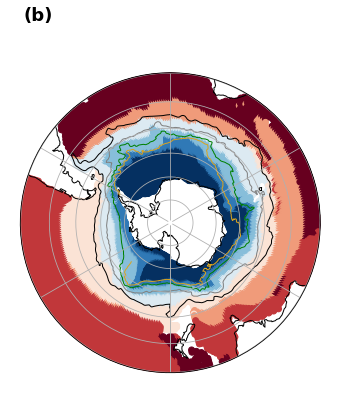

In [12]:
proj = ccrs.SouthPolarStereo()
front_colors=['black','grey','green',(218/256,165/256,32/256)]
colormap = plt.get_cmap('RdBu_r', n_classes)

fig=plt.figure(figsize=(7,6))

ax = plt.subplot(1,1,1,projection=proj)
    
CS=ax.scatter(classes.lon,classes.lat,c=flt.modal_classes(classes['class'],dims=['time','run']),cmap=colormap,transform=ccrs.PlateCarree())
for indf,front in enumerate(fronts):
    ax.plot(front_data[front][:,0], front_data[front][:,1], lw = 1, ls='-', label=front.upper(),color=front_colors[indf],transform=ccrs.PlateCarree())

#leg = ax.legend(bbox_to_anchor=( 1.25,1.2), ncol=4, \
#                         columnspacing = 0.8)
#leg = ax.legend(ncol=4, columnspacing = 0.8)

# set the linewidth of each legend object
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(5.0)

# compute a circle in axes coordinates, 
# which we can use as a boundary for the map.
theta = np.linspace(0, 2*np.pi, 100)
center = [0.5, 0.5]
radius = 0.46   # 0.46 corresponds to roughly 30S Latitude
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

# Add features
ax.gridlines()
#ax.add_feature(cfeature.LAND)
ax.coastlines()
ax.text(0.05,1.12,'(b)',transform=ax.transAxes,fontsize=18,fontweight='bold')

#colorbar = plt.colorbar(CS)
#dclass=(n_classes-1)/n_classes
#cticks = np.arange(dclass/2, n_classes-1, dclass)
#clabels=np.arange(1,n_classes+1,1)
#colorbar.set_ticks(cticks)
#colorbar.set_ticklabels(clabels)
#colorbar.set_label('Class', rotation=270, labelpad=10)

plt.savefig('figures/8class_lonlat_ensmean.pdf',bbox_inches='tight')

In [ ]:
from scipy.interpolate import interp1d
cmap = plt.get_cmap('RdBu_r', n_classes)
#fig = plt.figure(figsize=(22,6))
figure, axes = plt.subplots(2, n_classes, sharey=True,figsize=(19, 10))
    
m_id='ARGO (Jones 2019)'    
    
for (i, ax) in enumerate(axes[0]):    
    
    if i == 0:
        ax.set_ylabel('Depth / m')
        ax.invert_yaxis()
    if i == n_classes-1:
        ax.annotate(m_id,xy=(1.15,0.5),xycoords=ax.transAxes,fontsize=12,fontweight='bold',\
                     rotation='vertical',va='center')
    ax.text(0.85,0.05,str(i+1),fontweight='bold',fontsize=10,color='b',transform=ax.transAxes)
    
    ax.plot(J19_prof[i]['mean'],levs[:43],color=cmap(i),lw=3)
    ax.plot(J19_prof[i]['mean']+J19_prof[i]['std'],levs[:43],linestyle='--',color=cmap(i),lw=3)
    ax.plot(J19_prof[i]['mean']-J19_prof[i]['std'],levs[:43],linestyle='--',color=cmap(i),lw=3)
                            
    ax.set_ylim([1000,0])
    ax.set_xlim(-5,25)
    ax.grid(alpha=0.2)
  #  ax.set_xlabel('Temperature (°C)')
    if i==0:
        ax.set_ylabel('Depth / m')
        ax.text(0.05,1.05,'a)',transform=ax.transAxes,fontsize=14,fontweight='bold')
        
  #  ax.annotate("",xy=(0.6,0),xytext=(0.6+1.2*(g1[i]-i),-0.2),xycoords=ax.transAxes, \
   #                        arrowprops=dict(arrowstyle="<-",color='b',alpha=0.4,ls='-',mutation_scale=20,linewidth=2))  
        
m_id='UK-ESM (this study)'

for (i, ax) in enumerate(axes[1]):
    if i == 0:
        ax.set_ylabel('Depth / m')
    if i == n_classes-1:
        ax.annotate(m_id,xy=(1.15,0.5),xycoords=ax.transAxes,fontsize=12,fontweight='bold',\
                     rotation='vertical',va='center')
    ax.text(0.85,0.05,str(i+1),fontweight='bold',fontsize=10,color='b',transform=ax.transAxes)
            
    #Tmean = classes['profile_mean'].sel(classnum=i)
    #Tsig = classes['profile_std'].sel(classnum=i)

  #  ax.plot(Tmean.mean('run'),levs, color=cmap(i), linestyle='solid', linewidth=2)
   # ax.plot(Tmean.mean('run')+np.sqrt((Tsig**2).sum(dim='run')),levs, color=cmap(i), linestyle='dashed', linewidth=2)
   # ax.plot(Tmean.mean('run')-np.sqrt((Tsig**2).sum(dim='run')),levs, color=cmap(i), linestyle='dashed', linewidth=2)
    
    ax.plot(ensmean_profiles[i]['mean'],levs[:43], color=cmap(i), linestyle='solid', linewidth=3)
    #ax.plot(ensmean_profiles[i]['mean']+ensmean_profiles[i]['std'],levs[:43], color=cmap(i), linestyle=':', linewidth=3)
    #ax.plot(ensmean_profiles[i]['mean']-ensmean_profiles[i]['std'],levs[:43], color=cmap(i), linestyle=':', linewidth=2)
    ax.plot(ensmean_profiles[i]['mean']+ensmean_profiles[i]['std2'],levs[:43], color=cmap(i), linestyle='--', linewidth=3)
    ax.plot(ensmean_profiles[i]['mean']-ensmean_profiles[i]['std2'],levs[:43], color=cmap(i), linestyle='--', linewidth=3)
    
    ax.set_ylim([1000,0])
    ax.set_xlim(-5,25)
    ax.grid(alpha=0.2)
  #  ax.set_xlabel('Temperature (°C)')
    if i==0:
        ax.set_ylabel('Depth / m')
        ax.text(0.05,1.05,'b)',transform=ax.transAxes,fontsize=14,fontweight='bold')
        
  #  ax.annotate("",xy=(0.4,1),xytext=(0.4+1.2*(g2[i]-i),1.2),xycoords=ax.transAxes, \
  #                         arrowprops=dict(arrowstyle="<-",color='r',alpha=0.4,ls='-',mutation_scale=20,linewidth=2))        
        
plt.suptitle('{} Classes: UK-ESM and ARGO'.format(n_classes),fontsize=14,fontweight='bold',y=0.92)
    
figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Potential temperature / ${}^\circ$C')    

        # save and show the plot 
#plt.savefig('figures/8class_modelvargo.pdf', bbox_inches="tight")

Text(0.5, 0, 'Potential temperature / ${}^\\circ$C')